In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys

sys.path.insert(0, "../../src")

import matplotlib.pyplot as plt
import numpy as np
import torch
import h5py

from juart.dl.model.dc import DataConsistency
from juart.conopt.tfs.fourier import nonuniform_transfer_function
from juart.conopt.functional.fourier import nonuniform_fourier_transform_adjoint, fourier_transform_forward, fourier_transform_adjoint
from juart.vis.interactive import InteractiveFigure3D
from juart.dl.model.resnet import ResNet

In [2]:
kspace_cutoff = True
nX_cutoff, nY_cutoff, nZ_cutoff = 64, 64, 64
nX, nY, nZ, nTI, nTE = 156, 156, 156, 2, 1

In [3]:
data_path = "3DLiss_vd_preproc.h5"
with h5py.File(data_path, "r") as f:
    print(f"Dataset holds following data: {f.keys()}")

    print(f"Coilsensitivity info: {f['coilsens'].attrs['info']}")
    print(f"Trajectory info: {f['k'].attrs['info']}")
    print(f"Signal info: {f['d'].attrs['info']}")

    shape = (nX,nY,nZ,nTI)
    ktraj = torch.from_numpy(f['k'][:])
    coilsens = torch.from_numpy(f['coilsens'][:])
    d = torch.from_numpy(f['d'][:])

    print(f"Coilsensitivity shape {coilsens.shape}")
    print(f"Trajectory shape {ktraj.shape}")
    print(f"Signal shape {d.shape}")
    

Dataset holds following data: <KeysViewHDF5 ['coilsens', 'd', 'k']>
Coilsensitivity info: Shape (Channels, Nx, Ny, Nz).
Trajectory info: Shape (Dimensions, Samples, Echotimes). Scaled in units of cycle/fov
Signal info: Shape (Channels, Samples, Echotimes).
Coilsensitivity shape torch.Size([8, 156, 156, 156])
Trajectory shape torch.Size([3, 2001191, 2])
Signal shape torch.Size([8, 2001191, 2])


In [4]:
if kspace_cutoff:
    nX, nY ,nZ = nX_cutoff, nY_cutoff, nZ_cutoff
    shape = (nX, nY, nZ, nTI, nTE)
    
    mask = torch.linalg.norm(ktraj,dim=0) <= nX_cutoff//2
    
    ktraj = torch.stack(
        [ktraj[:, mask[:, echo], echo] for echo in range(ktraj.shape[2])],
        dim=-1
    )
    
    d = torch.stack(
        [d[:, mask[:, echo], echo] for echo in range(d.shape[2])],
        dim=-1
    )

    coilsens_ksp = fourier_transform_forward(coilsens, axes=(1,2,3))
    low_lim, up_lim = int(156/2 - nX/2), int(156/2 + nX/2)
    coilsens_ksp = coilsens_ksp[:, low_lim:up_lim, low_lim:up_lim, low_lim:up_lim]
    coilsens = fourier_transform_adjoint(coilsens_ksp, axes=(1,2,3))

In [5]:
k_scaled = ktraj / (2*ktraj.max())

In [6]:
AHd = nonuniform_fourier_transform_adjoint(k_scaled,d,(nX, nY, nZ))
AHd = torch.sum(torch.conj(coilsens[...,None]) * AHd, dim=0)

In [7]:
AHd_unsqueeze = AHd.unsqueeze(-1)
k = k_scaled.unsqueeze(-1)

In [8]:
data = {"images_regridded" : AHd_unsqueeze,
        "kspace_trajectory" : k,
        "sensitivity_maps" : coilsens}

In [9]:
dc_block = DataConsistency(
    shape,
    axes = (1,2,3),
    device="cpu",
    verbose = True,
    niter = 80
)

In [10]:
dc_block.init(
    data["images_regridded"],
    data["kspace_trajectory"],
    sensitivity_maps=data["sensitivity_maps"],
)

In [11]:
with torch.no_grad():
    cg_sense = dc_block(data["images_regridded"])

[CG] Iter: 79 Res: 4.73E-04 : 100%|██████████| 80/80 [01:00<00:00,  1.33it/s]


In [12]:
resnet_image = torch.squeeze(cg_sense,dim=(3,4))
resnet_image_unsqueezed = resnet_image.unsqueeze(-1)
cg_image = resnet_image.abs()

interactive(children=(IntSlider(value=32, description='Dimension 3', max=64, min=1), Output()), _dom_classes=(…

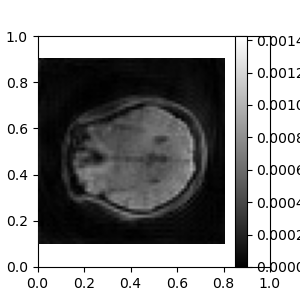

In [13]:
InteractiveFigure3D(
    torch.abs(cg_image[..., 0]).numpy(),
    vmin=0,
    vmax=cg_image.abs().max(),
    cmap="gray",
).interactive